In [95]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import BaggingClassifier
from scipy.stats import ttest_ind





In [96]:
results = pd.DataFrame.from_dict({'Classifier':'1', 'Dataset':'2', 'Training_Error':5, 'Testing_Error':6}, orient='index').T
results

,Classifier,Dataset,Training_Error,Testing_Error
0,1,2,5,6


In [97]:
%%cmd 
dir

Microsoft Windows [Version 6.1.7601]
Copyright (c) 2009 Microsoft Corporation. Alle Rechte vorbehalten.

(PDSH_mod) C:\Users\Tobsecret\Desktop\Lectures\Topics in Bioinformatics\Module 2 Molecular Classification of Cancer\Golub_dataset_Class_Prediction_Python
> dir
 Datentr„ger in Laufwerk C: ist Acer
 Volumeseriennummer: E6C9-99F6

 Verzeichnis von C:\Users\Tobsecret\Desktop\Lectures\Topics in Bioinformatics\Module 2 Molecular Classification of Cancer\Golub_dataset_Class_Prediction_Python

21.02.2017  16:13    <DIR>          .
21.02.2017  16:13    <DIR>          ..
13.02.2017  21:21    <DIR>          .ipynb_checkpoints
13.02.2017  21:46         1.860.352 data_set_ALL_AML_independent.tsv
14.02.2017  11:02         2.046.810 data_set_ALL_AML_train.tsv
20.02.2017  16:39             6.667 environment.txt
21.02.2017  16:13           231.342 Golub_dataset_Class_Prediction.ipynb
20.02.2017  16:12             1.087 LICENSE
21.02.2017  10:50               986 README.md
13.02.2017  22:18         

#### Reading in the datasets
We'll read in the test into the variable **test** and the training dataset into the variable **train**.

In [98]:
test = pd.read_csv('data_set_ALL_AML_independent.tsv', sep='\t', header=0, index_col=0)

In [99]:
train = pd.read_csv('data_set_ALL_AML_train.tsv', sep='\t', header=0, index_col=0)
train.drop(train.columns[len(train.columns)-1], axis=1, inplace=True)

In [100]:
#The sample_table contains the labels AML/ ALL 
sample_table = pd.read_csv('table_ALL_AML_samples.txt', sep='\t')
sample_table['Idealized'] = 0
sample_table['Idealized'].loc[sample_table['ALL/AML']=='ALL'] = 1


C:\Users\Tobsecret\Anaconda3\envs\PDSH_mod\lib\site-packages\pandas\core\indexing.py:132: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


##### Normalizing the Data
We normalize each element x by subtracting the row minimum and dividing by (row maximum minus row minimum).

x = (x - row_min) / (row_max - row_min)

In [101]:
norm_train = train.iloc[:,1::2].apply(lambda x: (x - np.min(x))/(np.max(x)-np.min(x)), axis=1)

In [102]:
norm_test = test.iloc[:,1::2].apply(lambda x: (x - np.min(x))/(np.max(x)-np.min(x)), axis=1)
norm_test = norm_test.reindex_axis(sorted(norm_test.columns, key=int), axis=1)

In [103]:
# Sorting the columns numerically
norm_train = norm_train.reindex_axis(sorted(list(norm_train.columns.values), key=int), axis=1)


#### K-nearest neighbours
We will try out various different selections of the data and train a separate model for each.
Let's start with the whole data set.


In [104]:
norm_train_transp = norm_train.T

In [105]:
neigh = KNeighborsClassifier()
neigh.fit(norm_train_transp, sample_table.iloc[:38,1:2].values.reshape(38))

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform')

Let's score on the training data set to see whether our model is reasonably trained.

In [106]:
neigh.score(norm_train.T, sample_table.iloc[:38,1:2].values.reshape(38))

0.94736842105263153

Let's score on the test set:

In [107]:
neigh.score(norm_test.T, sample_table.iloc[38:, 1:2].values.reshape(34))

0.70588235294117652

In [108]:
results = results.append(pd.Series({'Classifier':'K-nearest Neighbours', 'Dataset':'Normalized', 
                          'Training_Error':neigh.score(norm_train.T, sample_table.iloc[:38,1:2].values.reshape(38)), 
                          'Testing_Error':neigh.score(norm_test.T, sample_table.iloc[38:, 1:2].values.reshape(34))}),
              ignore_index=True)

#### K-nearest Neighbours Bagging Ensemble
In the following lines we'll try out the BaggingClassifier from scikit-learn and we will populate it with a K-nearest Neighbours Classifier.

In [109]:
bagging_neigh = BaggingClassifier(KNeighborsClassifier(), 
                                 max_samples=0.5, max_features=0.5)
bagging_neigh.fit(norm_train.T, sample_table.iloc[:38,1:2].values.reshape(38))
#

BaggingClassifier(base_estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform'),
         bootstrap=True, bootstrap_features=False, max_features=0.5,
         max_samples=0.5, n_estimators=10, n_jobs=1, oob_score=False,
         random_state=None, verbose=0, warm_start=False)

In [110]:
results = results.append(pd.Series({'Classifier':'Bagging Ensemble of K-nearest Neighbours', 'Dataset':'Normalized', 
                                    'Training_Error':bagging_neigh.score(norm_train.T, sample_table.iloc[:38,1:2].values.reshape(38)), 
                                    'Testing_Error':bagging_neigh.score(norm_test.T, sample_table.iloc[38:, 1:2].values.reshape(34))})
                         ,ignore_index=True)

#### Non-normalized Data
Let's try the same things with only a subset of genes and no normalization besides setting all values below 0 to 1.

In [111]:
non_negative_train = train.iloc[:,1::2].clip_lower(1)
non_negative_train 
non_negative_test = test.iloc[:, 1::2].clip_lower(1)

To separate the rubbish genes from the more predictive genes, we are doing independent sample Welch's t-tests for all genes, comparing the value for each gene in the AML samples to that value for the same gene in the ALL samples.

In [112]:
#The following line computes the independent t-tests between the AML and ALL samples for every gene.
non_negative_train_ttest_pvals = non_negative_train.apply(lambda x: 1-ttest_ind(x.iloc[:26].values.reshape(26,1), x.iloc[26:].values.reshape(12,1), equal_var=False).pvalue , axis=1).iloc[:,:1]

The violin plot below shows the distribution of the results of the ttests. The values plotted are 1-pvalue for all the genes.
One can see that most genes actually have pretty good p-values. 

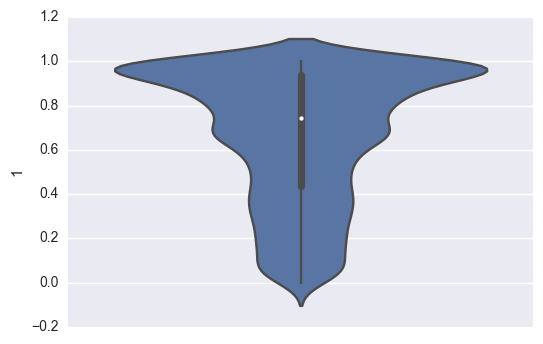

In [113]:
sns.violinplot( y="1", data=non_negative_train_ttest_pvals);


Now we'll select only the top 3000 genes based on the 1-pvalue scores, the lowest genesin this selection having a value of around 0.8 

In [114]:
top3000_ttest_mask = non_negative_train_ttest_pvals.sort_values('1', axis=0, ascending=False).head(3000).index

In [115]:
top3000_non_negative_train = non_negative_train.loc[top3000_ttest_mask]
top3000_non_negative_test = non_negative_test.loc[top3000_ttest_mask]

In [116]:
topneigh = KNeighborsClassifier()
topneigh.fit(top3000_non_negative_train.T, sample_table.iloc[:38,1:2].values.reshape(38))
print('Training Prediction Performance: ', 
      topneigh.score(top3000_non_negative_train.T, sample_table.iloc[:38,1:2].values.reshape(38)),
      ' Testing Prediction Performance: ',
      topneigh.score(top3000_non_negative_test.T, sample_table.iloc[38:, 1:2].values.reshape(34)))
results = results.append(pd.Series({'Classifier':'K-nearest Neighbours', 'Dataset':'Non-negative', 
                          'Training_Error':topneigh.score(top3000_non_negative_train.T, sample_table.iloc[:38, 1:2].values.reshape(38)), 
                          'Testing_Error' :topneigh.score(top3000_non_negative_test.T,  sample_table.iloc[38:, 1:2].values.reshape(34))}),
                        ignore_index=True)

Training Prediction Performance:  0.973684210526  Testing Prediction Performance:  0.617647058824


In [117]:
top_bagging_neigh = BaggingClassifier(KNeighborsClassifier(), 
                                 max_samples=0.5, max_features=0.5)
top_bagging_neigh.fit(top3000_non_negative_train.T, sample_table.iloc[:38,1:2].values.reshape(38))
print('Training Prediction Performance: ', 
      top_bagging_neigh.score(top3000_non_negative_train.T, sample_table.iloc[:38,1:2].values.reshape(38)),
      ' Testing Prediction Performance: ',
      top_bagging_neigh.score(top3000_non_negative_test.T, sample_table.iloc[38:, 1:2].values.reshape(34)))

results = results.append(pd.Series({'Classifier':'Bagging Ensemble of K-nearest Neighbours', 'Dataset':'Non-negative', 
                          'Training_Error':top_bagging_neigh.score(top3000_non_negative_train.T, sample_table.iloc[:38, 1:2].values.reshape(38)), 
                          'Testing_Error' :top_bagging_neigh.score(top3000_non_negative_test.T,  sample_table.iloc[38:, 1:2].values.reshape(34))}),
                        ignore_index=True)

Training Prediction Performance:  0.921052631579  Testing Prediction Performance:  0.529411764706


In [118]:
top_bagging_tree = BaggingClassifier(max_samples=0.5, max_features=0.5)

top_bagging_tree.fit(top3000_non_negative_train.T, sample_table.iloc[:38,1:2].values.reshape(38))
print('Training Prediction Performance: ', 
      top_bagging_tree.score(top3000_non_negative_train.T, sample_table.iloc[:38,1:2].values.reshape(38)),
      ' Testing Prediction Performance: ',
      top_bagging_tree.score(top3000_non_negative_test.T, sample_table.iloc[38:, 1:2].values.reshape(34)))
results = results.append(pd.Series({'Classifier':'Bagging Ensemble of Decision Trees', 'Dataset':'Non-negative', 
                          'Training_Error': top_bagging_tree.score(top3000_non_negative_train.T, sample_table.iloc[:38,1:2].values.reshape(38)), 
                          'Testing_Error' :top_bagging_tree.score(top3000_non_negative_test.T, sample_table.iloc[38:, 1:2].values.reshape(34))}),
                        ignore_index=True)

Training Prediction Performance:  0.947368421053  Testing Prediction Performance:  0.588235294118


In [119]:
 results = results.iloc[1:,:]

In [120]:
results['Training_Error'] = 1- results['Training_Error']
results['Testing_Error']  = 1-results['Testing_Error']
results

,Classifier,Dataset,Training_Error,Testing_Error
1,K-nearest Neighbours,Normalized,0.0526316,0.294118
2,Bagging Ensemble of K-nearest Neighbours,Normalized,0.157895,0.323529
3,K-nearest Neighbours,Non-negative,0.0263158,0.382353
4,Bagging Ensemble of K-nearest Neighbours,Non-negative,0.0789474,0.470588
5,Bagging Ensemble of Decision Trees,Non-negative,0.0526316,0.411765


#### Plotting the Results
Below are plots of the different combinations of data sets and classifiers.
The data sets are *non-negative*, i.e. negative expression values are set to 1 and only the top 3000 genes were considered, and *normalized*, i.e. for each expression value x:

x --> (x - row_min) / (row_max - row_min)

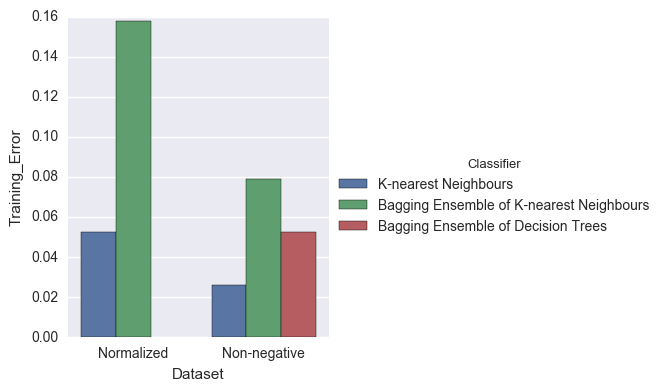

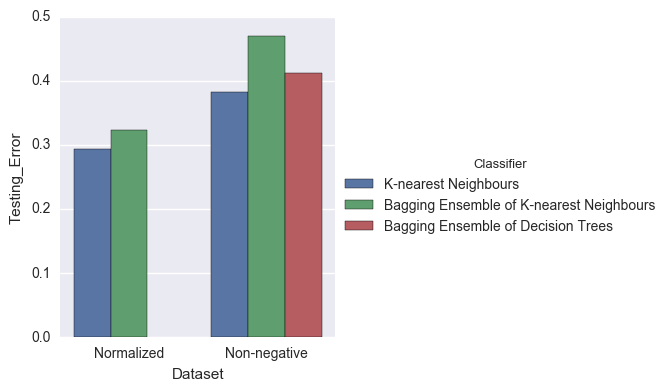

In [121]:
ax = sns.factorplot(x='Dataset', y='Training_Error', kind='bar', hue='Classifier', data=results)
ax = sns.factorplot(x='Dataset', y='Testing_Error', kind='bar', hue='Classifier', data=results)


As we can see, none of the classifiers did as well as the one done by Golub. The classifiers trained on the normalized full training data did better, with the K-nearest neighbours outperforming the bagging classifier with K-nearest neighbours.
If one was to continue the analysis, one would test more different combinations of normalizing/ narrowing down the datasets and test more combinations of classifiers and train them on a subset of the training data and test them on an independent subset of training data to pick the best classifier and use that one to score on the test data.